[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/LastCodeBender42/Protein-Structure-Network-Analysis.git/main?labpath=3d_protein_structure_network.ipynb)

# 3D Visualization on the Protein Structure Network
---

In [1]:
import pandas as pd
import plotly.graph_objs as go
import networkx as nx
import numpy as np
import ipywidgets as widgets
from IPython.display import display


class CentralityAnalysis:
    def __init__(self):
        super().__init__()
        # Initialize graph variable
        self.G = None
        
    def generate_graph(self):
        # Read data and create graph
        df = pd.read_csv('./data/1YOK.cif_ringEdges', sep='\t')
        subset_df = df.loc[(df['NodeId1'].str.contains('A:')) & (df['NodeId2'].str.contains('A:'))]
        subset_df = subset_df[['NodeId1', 'NodeId2']]
        subset_df['NodeId1'] = subset_df['NodeId1'].str.replace('A:', '')
        subset_df['NodeId2'] = subset_df['NodeId2'].str.replace('A:', '')
        subset_df['NodeId1'] = subset_df['NodeId1'].str.replace(':_:', ':')
        subset_df['NodeId2'] = subset_df['NodeId2'].str.replace(':_:', ':')
        self.G = nx.from_pandas_edgelist(subset_df, 'NodeId1', 'NodeId2', create_using=nx.Graph())
        
    def generate_eigenVals(self):
        # Check if graph is generated
        if self.G is None:
            raise ValueError("Graph not generated. Call generate_graph() first.")
        
        eigen_centr = nx.eigenvector_centrality_numpy(self.G)
        eigendf = pd.DataFrame(list(eigen_centr.items()), columns=['node', 'value'])
        eigendf['norm_val'] = eigendf['value'] / eigendf['value'].max()
        return eigendf
        
    def generate_closeVals(self):
        if self.G is None:
            raise ValueError("Graph not generated. Call generate_graph() first.")
        
        close_centr = nx.closeness_centrality(self.G)
        closedf = pd.DataFrame(list(close_centr.items()), columns=['node', 'value'])
        closedf['norm_val'] = closedf['value'] / closedf['value'].max()
        return closedf
        
    def generate_degrVals(self):
        if self.G is None:
            raise ValueError("Graph not generated. Call generate_graph() first.")
        
        degr_centr = nx.degree_centrality(self.G)
        degrdf = pd.DataFrame(list(degr_centr.items()), columns=['node', 'value'])
        degrdf['norm_val'] = degrdf['value'] / degrdf['value'].max()
        return degrdf
        
    def generate_betwVals(self):
        if self.G is None:
            raise ValueError("Graph not generated. Call generate_graph() first.")
        
        betw_centr = nx.betweenness_centrality(self.G)
        betwdf = pd.DataFrame(list(betw_centr.items()), columns=['node', 'value'])
        betwdf['norm_val'] = betwdf['value'] / betwdf['value'].max()
        return betwdf
            
    def generate_edgeBetw(self):
        if self.G is None:
            raise ValueError("Graph not generated. Call generate_graph() first.")
        
        edge_betw = nx.edge_betweenness_centrality(self.G)
        edge_betwdf = pd.DataFrame(list(edge_betw.items()), columns=['Pair', 'Edge Value'])
        edge_betwdf[['Node1', 'Node2']] = pd.DataFrame(edge_betwdf['Pair'].tolist(), index=edge_betwdf.index)
        edge_betwdf = edge_betwdf[['Node1', 'Node2', 'Edge Value']]
        edge_betwdf['Norm Value'] = edge_betwdf['Edge Value'] / edge_betwdf['Edge Value'].max()
        return edge_betwdf

def plotly_network(scale=1, centrality_measure='eigenVals'):

    edge_list_file = "./data/1yok.txt"  # Replace with your file path

    # Read edge list file and process data
    edges = []
    with open(edge_list_file, "r") as file:
        for line in file:
            source, target, *_ = line.strip().split()  # Assuming at least two columns separated by space or tab
            edges.append((source, target))

    # Initialize CentralityAnalysis instance
    newGraph = CentralityAnalysis()
    newGraph.generate_graph()
    
    G = nx.Graph()
    G.add_edges_from(edges)

    data_dict = {}

    # Open the file
    with open(edge_list_file, "r") as file:
        for line in file:
            columns = line.strip().split()  # Assumes columns are separated by whitespace
            key1 = columns[0]
            value1 = columns[2:5]
            key2 = columns[1]
            value2 = columns[4:7]
            data_dict[key1] = value1
            data_dict[key2] = value2

    # Convert values to arrays, skipping the first two entries
    for key, value in list(data_dict.items())[2:]:
        data_dict[key] = np.array(value, dtype=float)

    datasets = ['eigenVals', 'betwVals', 'degrVals', 'closeVals']
    dataframes = {}

    for dataset in datasets:
        df = getattr(newGraph, f'generate_{dataset}')()
        df['node'] = df['node'].str.replace(r'\D', '', regex=True)
        df['node'] = pd.to_numeric(df['node'])
        df = df.sort_values(by='node', ascending=True)
        df = df.drop(df.index[-1])
        dataframes[dataset] = df

    # Choose centrality measure
    chosen_centrality = dataframes[centrality_measure]

    # Scale node sizes based on centrality values
    node_size_scaling_factor = 100  # Adjust this factor to scale node sizes
    node_sizes = node_size_scaling_factor * chosen_centrality['norm_val']  # Use chosen centrality measure
    
    # Color nodes based on the number of connections in the network
    node_connections = chosen_centrality['value']
    min_connections = node_connections.min()
    max_connections = node_connections.max()
    normalized_connections = (node_connections - min_connections) / (max_connections - min_connections)
    node_colors = np.clip(normalized_connections * 10, 1, 10)  # Scale to range [1, 10]
    
    # Plot the 3D network graph with scaled node sizes and colored nodes
    edge_trace = go.Scatter3d(
        x=[],
        y=[],
        z=[],
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    for edge in G.edges():
        x0, y0, z0 = data_dict[edge[0]]
        x1, y1, z1 = data_dict[edge[1]]
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])
        edge_trace['z'] += tuple([z0, z1, None])

    node_trace = go.Scatter3d(
        x=[],
        y=[],
        z=[],
        text=[],  # Include node labels here
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='Viridis',
            color=node_colors,  # Color nodes based on legend scale
            size=node_sizes,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=2)))

    for node in G.nodes():
        x, y, z = data_dict[node]
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        node_trace['z'] += tuple([z])
        node_trace['text'] += tuple([f'Node {node}'])  # Add node labels here

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='Network Visualization',
                        titlefont=dict(size=16),
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002)]
                    ))

    fig.update_layout(template='ggplot2')
    fig.show()

# Create a dropdown widget for choosing centrality measure
centrality_dropdown = widgets.Dropdown(
    options=['eigenVals', 'betwVals', 'degrVals', 'closeVals'],
    value='eigenVals',
    description='Centrality Measure:',
    disabled=False,
)

# Create a slider widget for scaling the nodes
scale_slider = widgets.FloatSlider(
    min=0.1,
    max=2,
    step=0.1,
    value=1,
    description='Node Scale:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

# Register the update_plot function as a callback for the dropdown and slider widgets
widgets.interactive(plotly_network, scale=scale_slider, centrality_measure=centrality_dropdown)


interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Node Scale:', max=2.0, min=…

---
# **An Image of the Result:**
---

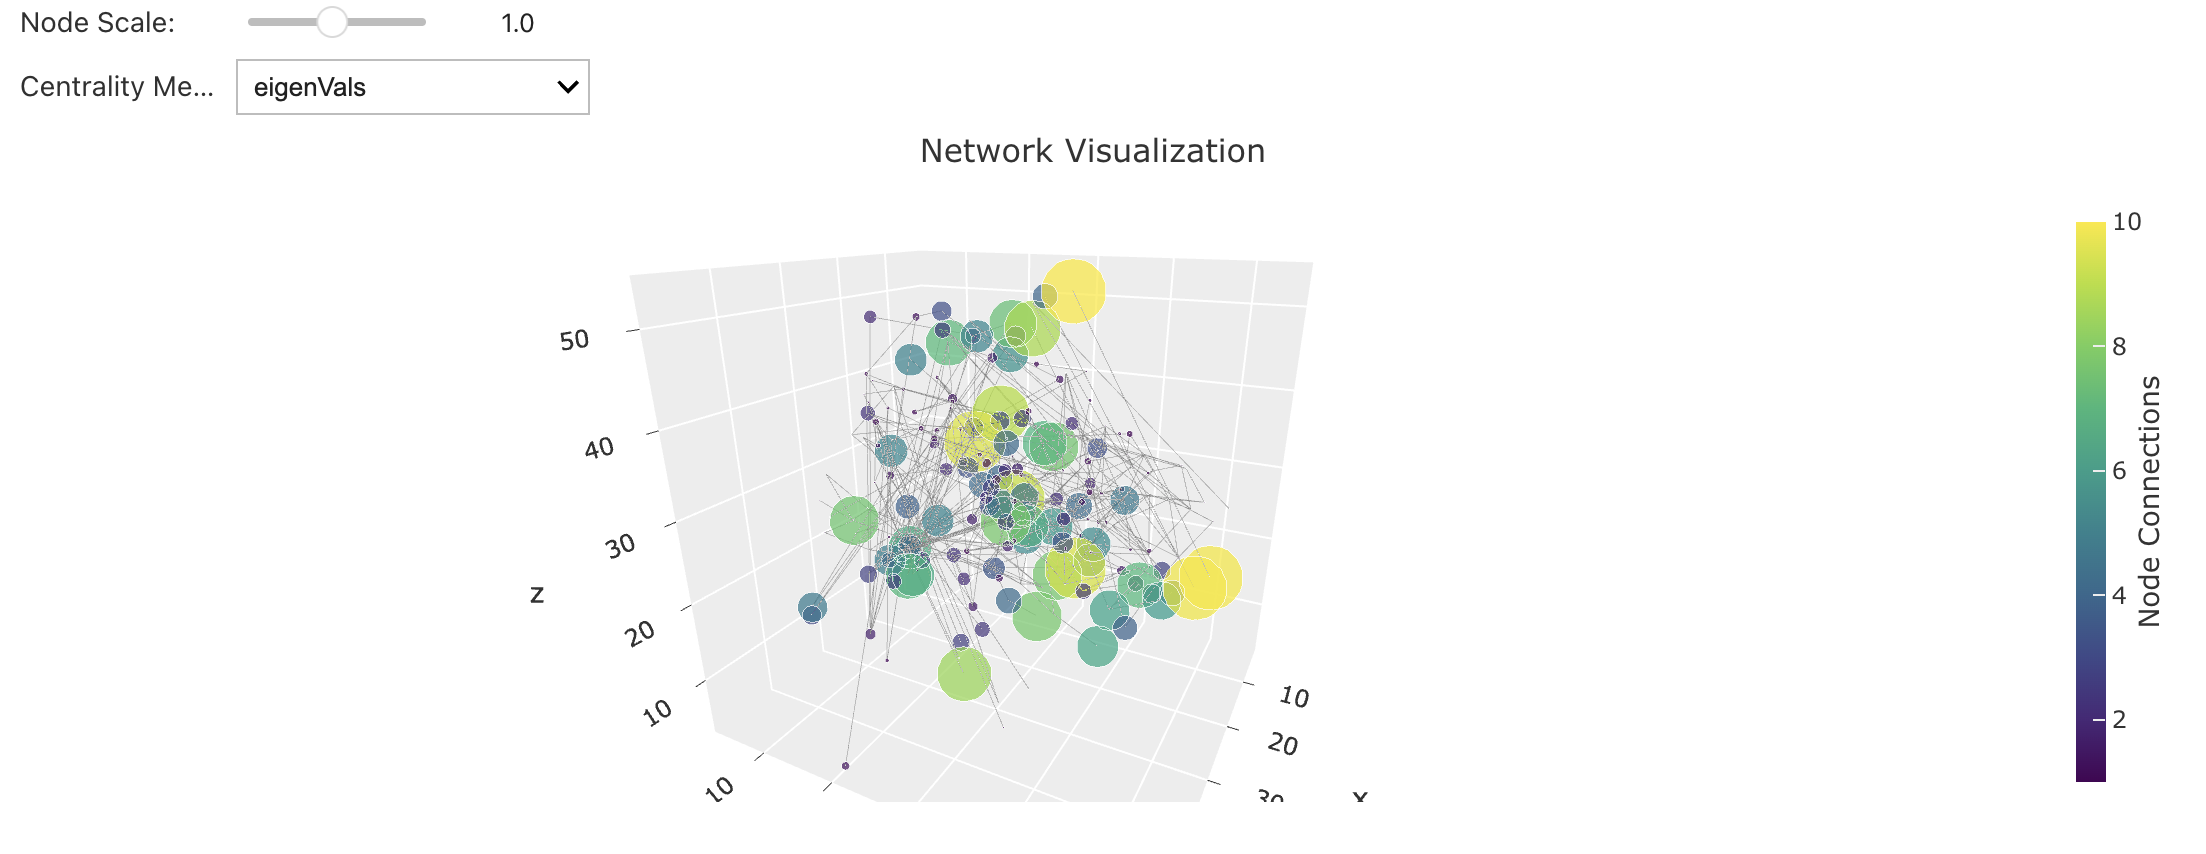